For running this, one needs to activate the `mubind` environment

In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import scanpy as sc
from os.path import join
from os import listdir
import anndata
import pandas as pd
import numpy as np
import scipy

Take a large AnnData and divide into several ones of same size

In [6]:
ls -ltrh /mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/scanvi*.h5ad

-rwxrwxrwx 1 rio rio 2.2G Jun 14 16:15 /mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/scanvibatch_E50_L2_H256.h5ad*
-rwxrwxrwx 1 rio rio 2.2G Jun 14 16:15 /mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/scanvibatch_E100_L2_H256.h5ad*
-rwxrwxrwx 1 rio rio 2.2G Jun 21 13:25 /mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/scanvi_E100_L2_H256.h5ad*
-rwxrwxrwx 1 rio rio 2.1G Jun 23 23:52 /mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/scanvi_E20_L2_H256.h5ad*


In [7]:
# ad_path = '/mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_500_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/prepare/unscaled/HVG.1K/adata_pre.h5ad'
tech = 'sn+sc'

# ad_path = '/mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/R/harmony.h5ad'
ad_path = os.path.join('/mnt/f/workspace/theislab/retina/data/integration_oct_2022/output',
                       'retina_all_cells_all_%s_batch_donor_dataset_cell.type_2022' % tech,
                       'integration/unscaled/HVG.1K/scanvi_E20_L2_H256.h5ad' )
ad_path, os.path.exists(ad_path)

('/mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_all_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/integration/unscaled/HVG.1K/scanvi_E20_L2_H256.h5ad',
 True)

In [8]:
adata = sc.read_h5ad(ad_path)

In [9]:
adata.shape

(2213518, 1000)

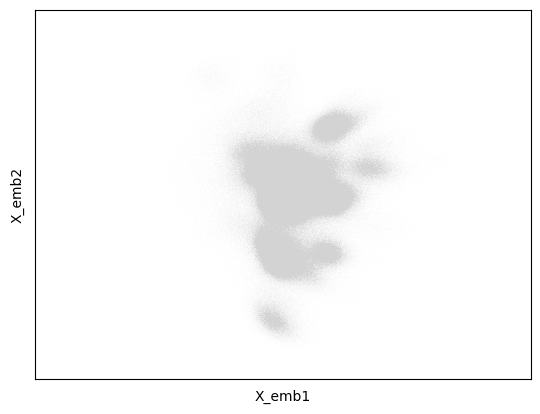

In [15]:
sc.pl.embedding(adata, basis='X_emb')

In [16]:
adata.obs.dataset.value_counts()

Chen_a      1180298
Chen_b       301946
Roska        222094
Chen_rgc     194119
Sanes        113002
Hackney      110986
Chang         63135
Wong          12100
Scheetz        8225
Hafler         7613
Name: dataset, dtype: int64

In [33]:
n_sample = None
if n_sample is not None:
    ad = adata[pd.Index(pd.Series(adata.obs_names).sample(n_sample))].copy()
else:
    ad = adata
# ad = ad[ad.obs['tech'] == 'sn'].copy()

In [34]:
## Neighbors with GPU should take about 30 minutes (ca.)

In [35]:
ad.shape

(2213518, 1000)

In [36]:
sc.pp.neighbors(ad, use_rep='X_emb', method='rapids')

In [37]:
sc.tl.umap(ad, method='rapids', min_dist=1, spread=1, random_state=100)

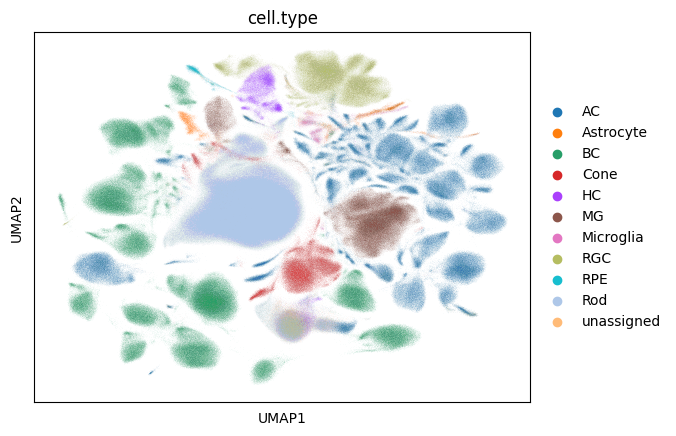

In [38]:
sc.pl.umap(ad, color='cell.type')

In [39]:
print('done...')

done...


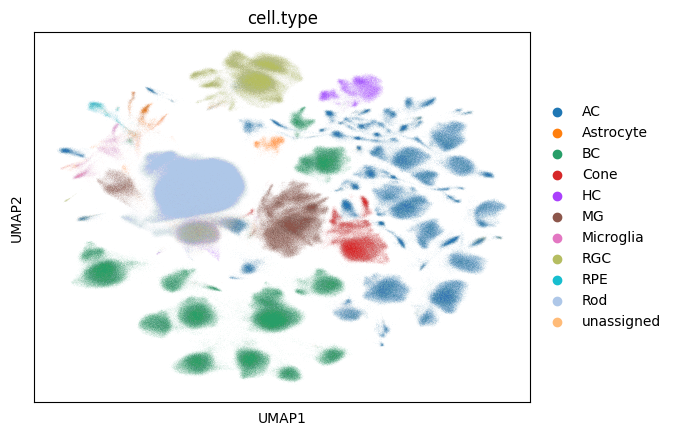

In [17]:
sc.pl.umap(ad, color='cell.type')

In [68]:
sn = ad[ad.obs['tech'] == 'sn']

In [70]:
sc.set_figure_params()

In [79]:
rcParams['figure.figsize'] = 8, 6

In [ ]:
sc.pl.umap(sn, color='cell.type')

In [ ]:
# others

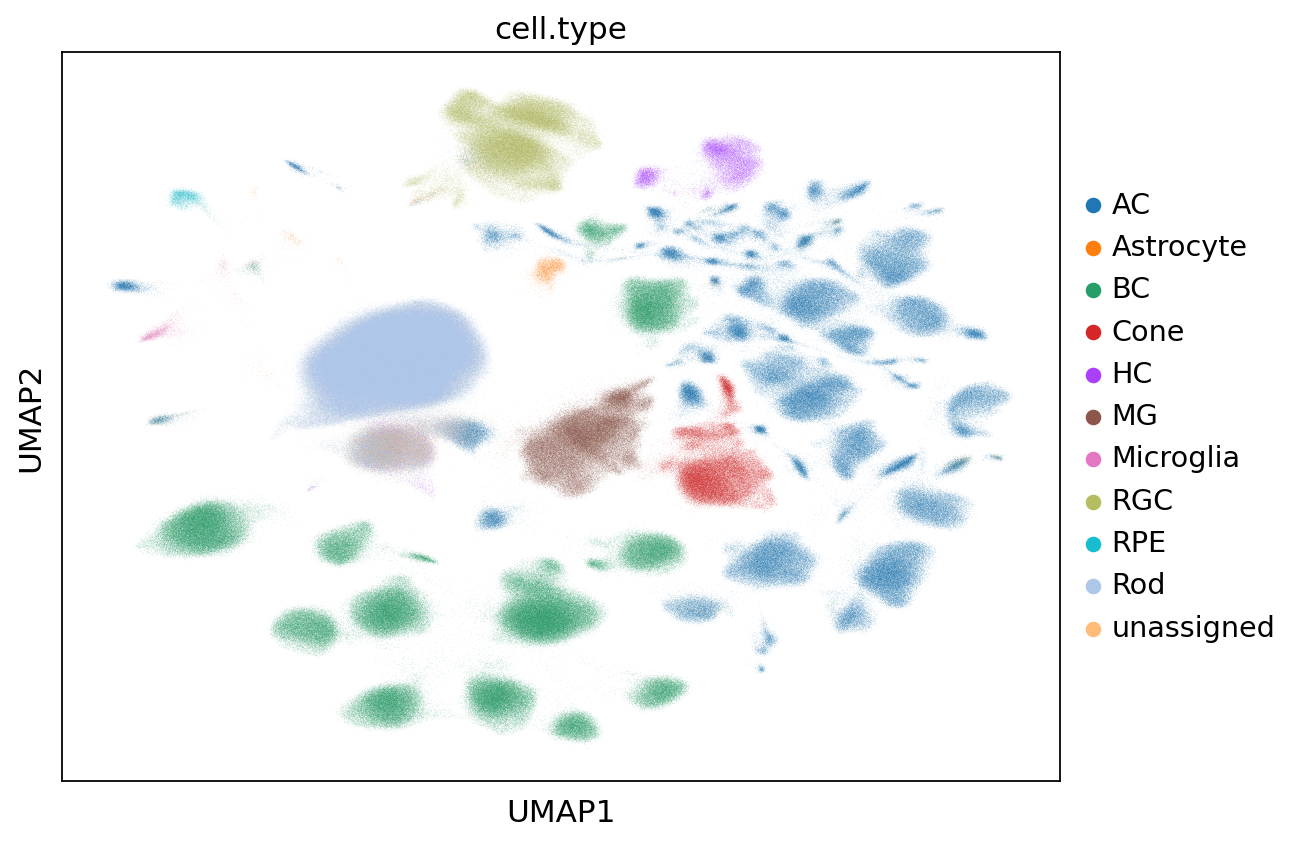

In [80]:

sc.pl.umap(sn, color='cell.type')

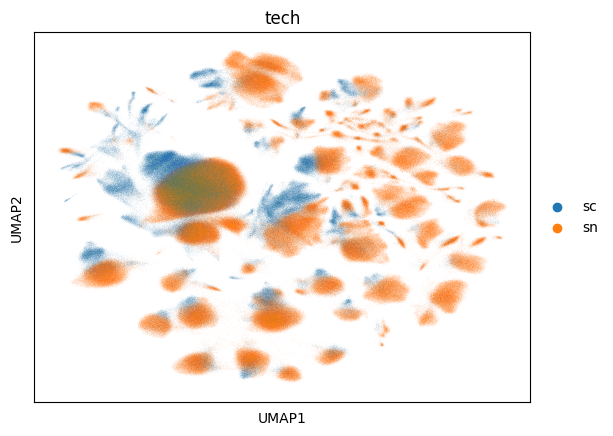

In [18]:
sc.pl.umap(ad, color='tech')

In [19]:
print('here...')

here...


Leiden for the full object might take about one hour

In [20]:
if not 'leiden' in ad.obs:
    sc.tl.leiden(ad)

We are interested in confirming the sizes of clusters by technology, to prevent biases

In [28]:
import seaborn as sns

In [42]:
counts = ad.obs.groupby(['leiden', 'tech']).size().reset_index().pivot('leiden', 'tech', 0)

In [45]:
prop = counts.copy()
for c in counts:
    prop[c] = counts[c] / counts.sum(axis=1)
prop

tech,sc,sn
leiden,,
0,0.134658,0.865342
1,0.146921,0.853079
2,0.038333,0.961667
3,0.154409,0.845591
4,0.168403,0.831597
...,...,...
56,0.022272,0.977728
57,0.999722,0.000278
58,0.071713,0.928287


tech,sc,sn
leiden,,
0,-0.365342,0.365342
1,-0.353079,0.353079
2,-0.461667,0.461667
3,-0.345591,0.345591
4,-0.331597,0.331597
...,...,...
56,-0.477728,0.477728
57,0.499722,-0.499722
58,-0.428287,0.428287


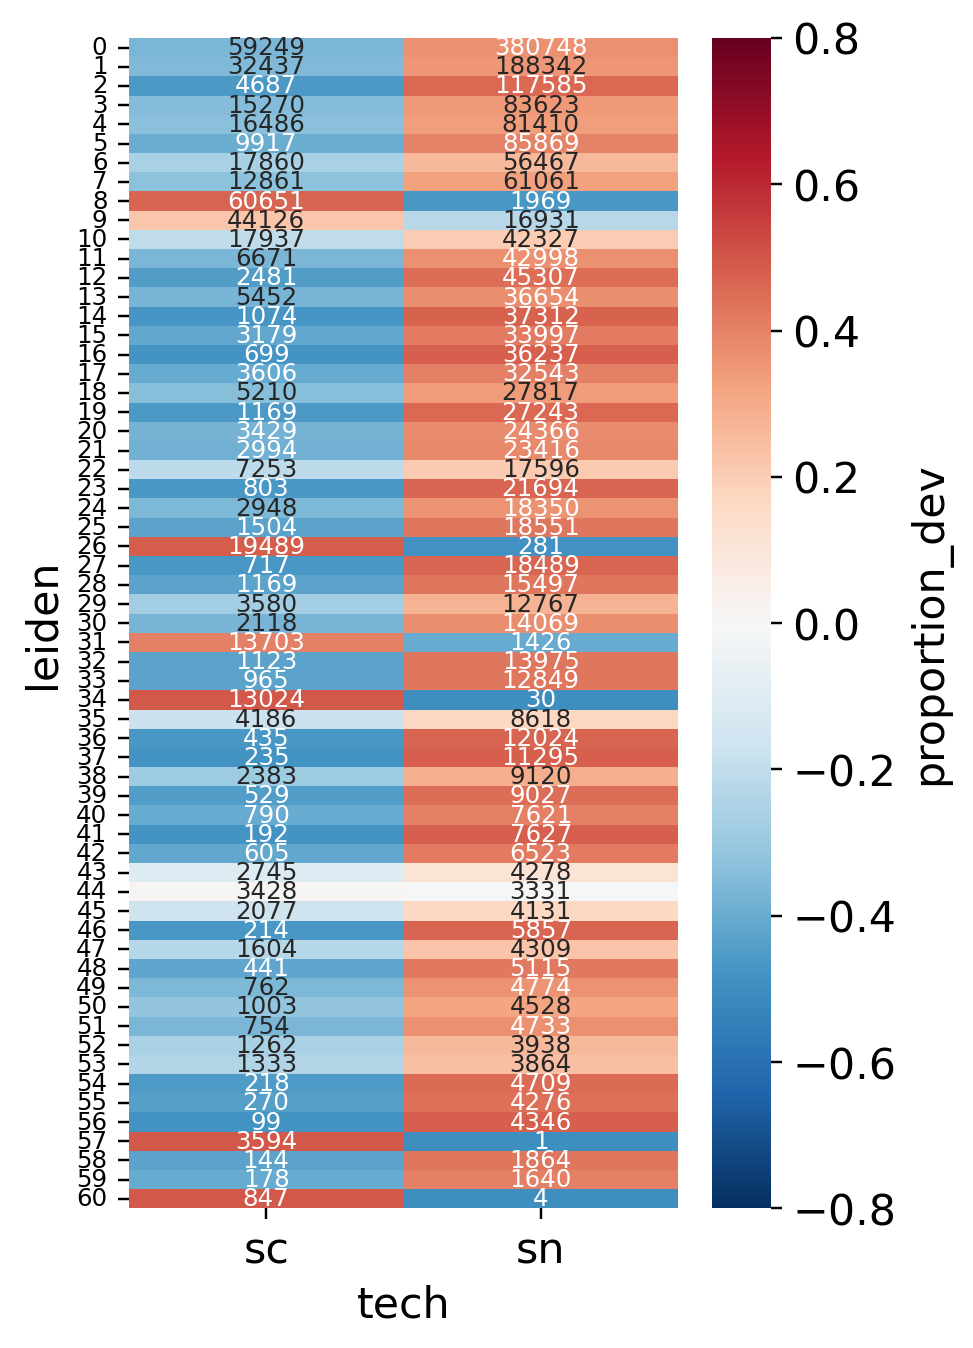

In [89]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 4, 7
rcParams['figure.dpi'] = 110
vmax = .8
sns.heatmap((prop - .5), annot=counts, vmin=-vmax, vmax=vmax,
            cmap='RdBu_r', fmt='',
            annot_kws={'fontsize': 8}, cbar_kws={'label': 'proportion_dev'},
            yticklabels=True)
plt.yticks(fontsize=8);

In [ ]:
sc.pl.umap(ad, color='leiden')

In [22]:
ad.shape

(2213518, 1000)

In [ ]:
print('here')
assert False

In [18]:
res = []
for min_dist in np.arange(.5, 1.5, .5):
    for spread in np.arange(1, 4, 1):
        # print(min_dist, spread)
        sc.tl.umap(ad,
                   method='rapids',
                   min_dist=min_dist,
                   spread=spread,
                   random_state=100)
        # sc.pl.umap(ad, color='cell.type')
        bc = ad[ad.obs['cell.type'] == 'BC'].obsm['X_umap']
        ac = ad[ad.obs['cell.type'] == 'AC'].obsm['X_umap']
        score = np.sqrt(np.sum((ac.mean(axis=0) - bc.mean(axis=0))**2))

        def get_mean_distance(ad, a, b):
            p = ad[ad.obs['leiden'] == a].obsm['X_umap']
            q = ad[ad.obs['leiden'] == b].obsm['X_umap']
            dist = np.sqrt(np.sum((p.mean(axis=0) - q.mean(axis=0))**2))
            return dist

        bc_ac = ad.obs[ad.obs['cell.type'].isin({'AC', 'BC'})]
        sizes = bc_ac.groupby(['leiden', 'cell.type']).size().reset_index().pivot('leiden', 'cell.type', 0)[['BC', 'AC']]
        ac = sizes[(sizes['AC'] > sizes['BC'])].index
        bc = sizes[(sizes['BC'] > sizes['AC'])].index

        inter_dist = []
        for a in ac:
            for b in bc:
                dist = get_mean_distance(ad, a, b)
                # print(a, b, dist)
                inter_dist.append(dist)

        self_dist_ac = []
        for a in ac:
            for b in ac:
                dist = get_mean_distance(ad, a, b)
                # print(a, b, dist)
                self_dist_ac.append(dist)

        self_dist_bc = []
        for a in bc:
            for b in bc:
                dist = get_mean_distance(ad, a, b)
                # print(a, b, dist)
                self_dist_bc.append(dist)


        res.append([min_dist, spread, score,
                    np.mean(self_dist_ac), np.mean(self_dist_bc),
                    np.mean(inter_dist)])
        print(res[-1])
res = pd.DataFrame(res, columns=['min_dist', 'spread', 'dist_ac_bc',
                                 'self_dist_ac', 'self_dist_bc', 'inter_dist'])

: 

: 

: 

In [ ]:
res.sort_values('inter_dist', ascending=False)


,min_dist,spread,dist_ac_bc,self_dist_ac,self_dist_bc,inter_dist
5,1.0,3,3.9115112,20.385391,22.970245,22.459877
2,0.5,3,4.858456,20.726498,21.905384,22.081877
4,1.0,2,1.350357,18.783709,19.939726,20.166233
1,0.5,2,1.4148397,15.156024,19.788004,18.420294
3,1.0,1,3.4842637,12.093325,15.662724,14.869652
0,0.5,1,3.65555,12.181543,13.684877,14.015693


In [ ]:
res['inter_dist'] = -res['inter_dist']
res['rank_score'] = res[res.columns[-3:]].rank().sum(axis=1).rank()
res['inter_dist'] = -res['inter_dist']
res.sort_values('rank_score')

,min_dist,spread,dist_ac_bc,self_dist_ac,self_dist_bc,inter_dist,rank_score
3,1.0,1,3.4842637,12.093325,15.662724,14.869652,1.0
0,0.5,1,3.65555,12.181543,13.684877,14.015693,2.0
1,0.5,2,1.4148397,15.156024,19.788004,18.420294,3.0
4,1.0,2,1.350357,18.783709,19.939726,20.166233,4.0
5,1.0,3,3.9115112,20.385391,22.970245,22.459877,5.0
2,0.5,3,4.858456,20.726498,21.905384,22.081877,6.0


In [ ]:
min_dist = res.sort_values('rank_score')['min_dist'].values[0]
spread = res.sort_values('rank_score')['spread'].values[0]
print(min_dist, spread)
# 1.0	1 these values generate weird outliers in the full dataset.
sc.tl.umap(ad, method='rapids', min_dist=.5, spread=1, random_state=100)

1.0 1


In [ ]:
ad.shape

(426169, 1000)

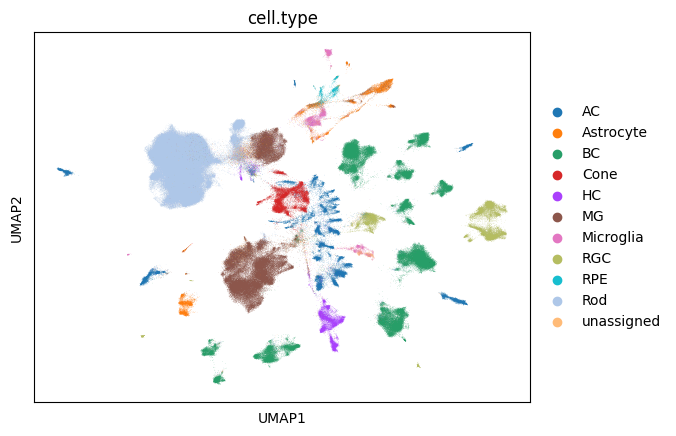

In [ ]:
sc.pl.umap(ad, color='cell.type')

In [ ]:
ad.sha

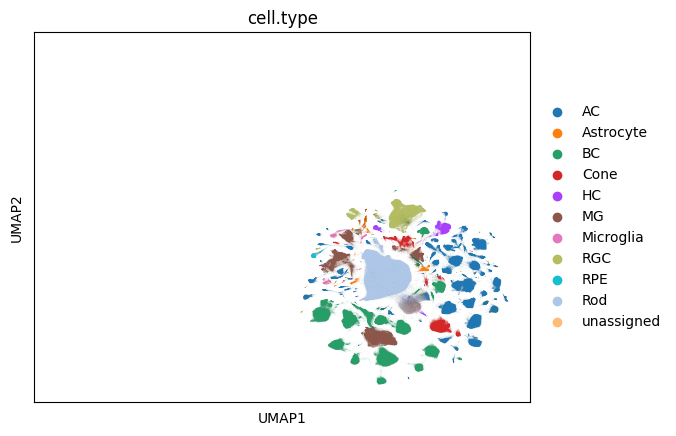

In [ ]:
# 1.0	1 these values generate weird outliers in the full dataset.
sc.tl.umap(ad, method='rapids', min_dist=min_dist, spread=spread, random_state=100, init_pos='random')

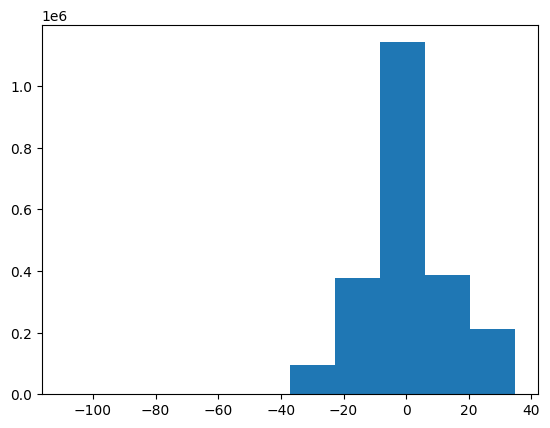

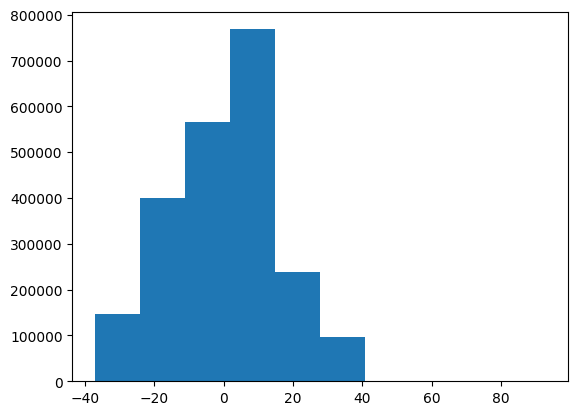

In [ ]:
import matplotlib.pyplot as plt
x, y = ad.obsm['X_umap'][:,0], ad.obsm['X_umap'][:,1]
plt.hist(x);
plt.show()
plt.hist(y);
plt.show()


In [ ]:
pd.Series(x).describe()

count    2.213518e+06
mean     7.180288e-02
std      1.297352e+01
min     -1.091561e+02
25%     -7.363567e+00
50%     -1.648790e+00
75%      7.705918e+00
max      3.479646e+01
dtype: float64

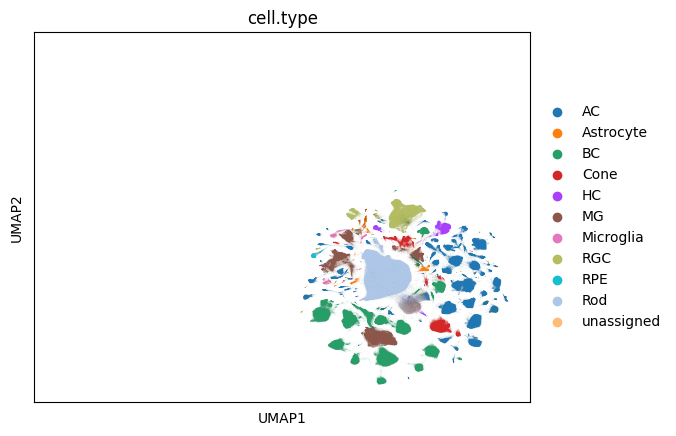

In [ ]:
sc.pl.umap(ad, color='cell.type')

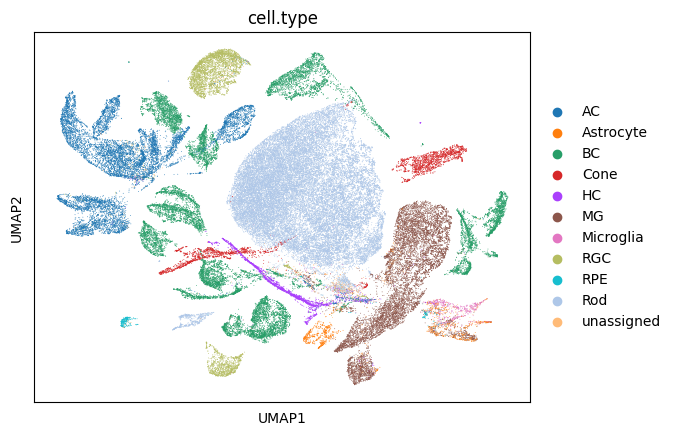

In [ ]:
sc.tl.umap(adata, method='rapids', spread=1.2)
sc.pl.umap(adata, color='cell.type')